In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
from src import AFDB_tools, treescore , foldseek2tree
import pandas as pd
import torch

In [4]:
#load cath dataset from CATH data folder with comment lines as # and white space seperator
domain_df = pd.read_csv('../CATH_data/cath-domain-list.txt' , comment='#' , header = None , delim_whitespace=True)
print(domain_df.head())

        0   1   2   3   4   5   6   7   8   9   10     11
0  1oaiA00   1  10   8  10   1   1   1   1   1  59    1.0
1  1go5A00   1  10   8  10   1   1   1   1   2  69  999.0
2  3frhA01   1  10   8  10   2   1   1   1   1  58    1.2
3  3friA01   1  10   8  10   2   1   1   1   2  54    1.8
4  3b89A01   1  10   8  10   2   1   1   2   1  54    2.6


In [5]:
#change the type to string
domain_df = domain_df.astype(str)
domain_df['superfam'] = domain_df[[1,2,3,4]].apply(lambda x : '.'.join(x), axis = 1) 
domain_df['CAT'] = domain_df[[1,2,3]].apply(lambda x : '.'.join(x), axis = 1) 


In [6]:
siftsdf = pd.read_csv('../CATH_data/pdb_chain_cath_uniprot.csv', header=1 )

In [7]:
#merge with domain df on cath id
siftsdf = siftsdf.merge(domain_df, left_on = 'CATH_ID' , right_on = 0 , how = 'left')
siftsdf = siftsdf.dropna()
print(siftsdf.head(), len(siftsdf) , print(len(siftsdf.superfam.unique())))

6485
    PDB CHAIN SP_PRIMARY  CATH_ID        0  1   2    3   4  5  6  7   8  9  \
0  101m     A     P02185  101mA00  101mA00  1  10  490  10  1  1  1  51  4   
1  102l     A     P00720  102lA00  102lA00  1  10  530  40  1  1  2  30  2   
2  102m     A     P02185  102mA00  102mA00  1  10  490  10  1  1  1  42  7   
3  103l     A     P00720  103lA00  103lA00  1  10  530  40  1  1  2  69  2   
4  103m     A     P02185  103mA00  103mA00  1  10  490  10  1  1  1  42  8   

    10    11     superfam       CAT  
0  154  2.07  1.10.490.10  1.10.490  
1  163  1.74  1.10.530.40  1.10.530  
2  154  1.84  1.10.490.10  1.10.490  
3  159   1.9  1.10.530.40  1.10.530  
4  154  2.07  1.10.490.10  1.10.490   451320 None


['1.10.490.10' '1.10.530.40' '3.40.30.10' ... '6.10.140.1500'
 '1.20.120.1500' '1.10.10.1760'] 6485


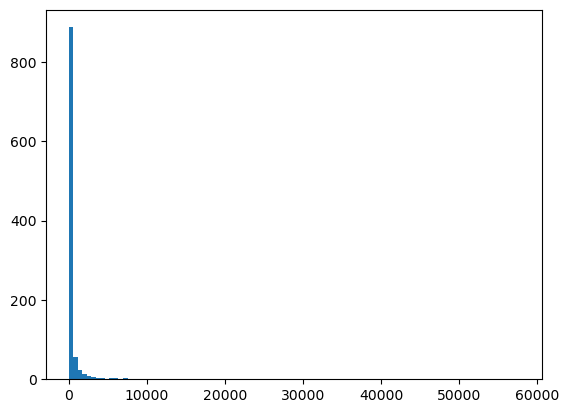

In [8]:
from matplotlib import pyplot as plt
print(siftsdf.superfam.unique(),len(siftsdf.superfam.unique()))
#make a histogram of the superfam counts
famsizes = siftsdf.CAT.value_counts().to_numpy()
plt.hist( famsizes[famsizes>10] , bins = 100)
plt.show()

In [9]:
import urllib.request
from Bio import PDB
import warnings
import os


def dlchain(pdb_id , chainID , savepath):
    
    try:
        if  os.path.isfile(savepath)==False:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                pdbl = PDB.PDBList()
                pdb_file = pdbl.retrieve_pdb_file(pdb_id , file_format = 'pdb' )
                structure = PDB.PDBParser().get_structure(pdb_id, pdb_file )
                chain_A = None
                for model in structure:
                    for chain in model:
                        if chain.id == chainID:
                            chain_A = chain
                            break
                    if chain_A:
                        break

                if chain_A:
                    io = PDB.PDBIO()
                    io.set_structure(chain_A)
                    io.save(savepath)
                else:
                    print("err", savepath)
    except:
        print('err' , savepath)


In [ ]:
from src import AFDB_tools
import os
import shutil
import random
import glob



#datapath = '../CATH_data/'

datapath = '../CAT_data/'

nprots = 250
fams = 2000
clear = False
total = 0
lengths = []
#iterate over all superfamilies and create a tree for each
if not os.path.exists(datapath):
    os.mkdir(datapath)

if clear == True:
    print('clearing folders')
    for folder in [datapath]:
        subfolders = glob.glob(folder+'*/')
        for sub in subfolders:
            shutil.rmtree(sub)

for i,superfam in enumerate(siftsdf.CAT.unique()):
    if not os.path.exists(datapath+superfam):
        os.mkdir(datapath+superfam)
    #create a tree for each superfam
    #sample 1000 proteins from the superfam
    sub = siftsdf[siftsdf.CAT == superfam]
    prots = list( set(sub['SP_PRIMARY'].unique()) )
    #output the sequence dataset to a file
    #create a folder for the superfam if it does not exist
    #output the uniport ids to a file
    if len(prots)> 100:
        random.shuffle(prots)
        prots = prots[:nprots]
        print(len(prots))
        
        
        lengths.append(len(prots))
        total+=1
        with open(datapath+superfam+'/identifiers.txt', 'w') as f:
            f.write('\n'.join( prots ))
            
        if not os.path.exists(datapath+superfam+'/structs/'):
            os.mkdir(datapath+superfam+'/structs/')
        protdict = dict(zip( sub['SP_PRIMARY'] , sub.PDB ))
        protdict = {p:protdict[p] for p in prots }
        chaindict = dict(zip( sub['SP_PRIMARY'] , sub.CHAIN ))
        [ dlchain(pdb, chaindict[unid] , datapath+superfam+'/structs/'+unid.upper()+'.pdb') for unid,pdb in protdict.items() ] 
print('done', total)
plt.hist(lengths)
plt.show()


250
Structure exists: '/work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/snake_tree/notebooks/hd/pdb1hds.ent' 
Structure exists: '/work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/snake_tree/notebooks/hz/pdb2hz3.ent' 
Structure exists: '/work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/snake_tree/notebooks/yj/pdb4yjj.ent' 
Structure exists: '/work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/snake_tree/notebooks/lh/pdb1lht.ent' 
Structure exists: '/work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/snake_tree/notebooks/hy/pdb3hyu.ent' 
Structure exists: '/work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/snake_tree/notebooks/ar/pdb3arl.ent' 
Structure exists: '/work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/snake_tree/notebooks/bm/pdb6bme.ent' 
Structure exists: '/work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/snake_tree/notebooks/ig/pdb2ig3.ent' 
Structure exists: '/work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/snake_tree/notebooks/ub/pdb3ubv.ent' 
Structure exists: '/work/FAC/FBM/DBC/cdess

In [ ]:
from src import AFDB_tools
import os
import shutil
import random
import glob

datapath = '../CATH_data/'
unfiltered = '../CATH_data_unfiltered/'

nprots = 500
fams = 2000
clear = True
total = 0
lengths = []
#iterate over all superfamilies and create a tree for each
if not os.path.exists(datapath):
    os.mkdir(datapath)
if not os.path.exists(unfiltered):
    os.mkdir(unfiltered)
    
if clear == True:
    print('clearing folders')
    for folder in [datapath,unfiltered]:
        subfolders = glob.glob(folder+'*/')
        for sub in subfolders:
            shutil.rmtree(sub)

for i,superfam in enumerate(siftsdf.superfam.unique()):
    if not os.path.exists(datapath+superfam):
        os.mkdir(datapath+superfam)
    if not os.path.exists(unfiltered+superfam):
        os.mkdir(unfiltered+superfam)
    #create a tree for each superfam
    #sample 1000 proteins from the superfam
    sub = siftsdf[siftsdf.superfam == superfam]
    prots = list( set(sub['SP_PRIMARY'].unique()) )
    #output the sequence dataset to a file
    #create a folder for the superfam if it does not exist
    #output the uniport ids to a file
    if len(prots)> 100:
        random.shuffle(prots)
        prots = prots[:nprots]
        print(len(prots))
        lengths.append(len(prots))
        total+=1
        with open(datapath+superfam+'/identifiers.txt', 'w') as f:
            f.write('\n'.join( prots ))
        with open(unfiltered+superfam+'/identifiers.txt', 'w') as f:
            f.write('\n'.join( prots ))
print('done', total)
plt.hist(lengths)
plt.show()


In [ ]:
scopdf = pd.read_csv('../SCOP_data/pdb_chain_scop_uniprot.csv')
print(scopdf)

       FA-DOMID FA-PDBID    FA-PDBREG FA-UNIID  FA-UNIREG  SF-DOMID SF-PDBID  \
0       8045703     3H8D  C:1143-1264   Q64331  1143-1264   8091604     3H8D   
1       8094330     6J56  A:1158-1282   Q9UM54  1167-1291   8094331     6J56   
2       8017835     3FKQ      A:1-116   D0VX10      1-116   8017836     3FKQ   
3       8021315     1XHF      A:2-122   P0A9Q1      2-122   8033695     1XHF   
4       8021787     1Y7P     B:79-215   O28869     79-215   8034167     1Y7P   
...         ...      ...          ...      ...        ...       ...      ...   
36895   8022870     1SCJ    B:307-377   P04189     36-106   8035250     1SCJ   
36896   8027500     1T1E     A:12-188   Q8RR56     12-188   8039879     1T1E   
36897   8027593     1JQG    A:4P-100P   O97389     18-109   8039972     1JQG   
36898   8028119     1KN6       A:4-76   P63239     31-103   8040498     1KN6   
36899   8028297     1KWM     A:1A-95A   P15086     16-110   8040676     1KWM   

         SF-PDBREG SF-UNIID  SF-UNIREG 

(array([485.,  72.,  31.,  13.,   7.,   2.,   6.,   1.,   2.,   1.]),
 array([ 11. ,  61.7, 112.4, 163.1, 213.8, 264.5, 315.2, 365.9, 416.6,
        467.3, 518. ]),
 <BarContainer object of 10 artists>)

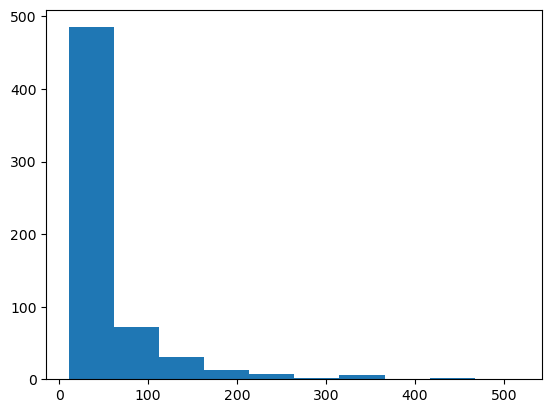

In [ ]:
scopdf = pd.read_csv('../SCOP_data/scop-cla-latest.txt', header = None, comment= '#' , sep = ' ')
scopdf.columns = 'FA-DOMID FA-PDBID FA-PDBREG FA-UNIID FA-UNIREG SF-DOMID SF-PDBID SF-PDBREG SF-UNIID SF-UNIREG SCOPCLA'.split()
scopdf['SF'] = scopdf['SCOPCLA'].map( lambda x : ''.join(x.split(',')[0-2]) )
print(scopdf)

vc = scopdf.SF.value_counts()
plt.hist( vc[vc>10])


done 64


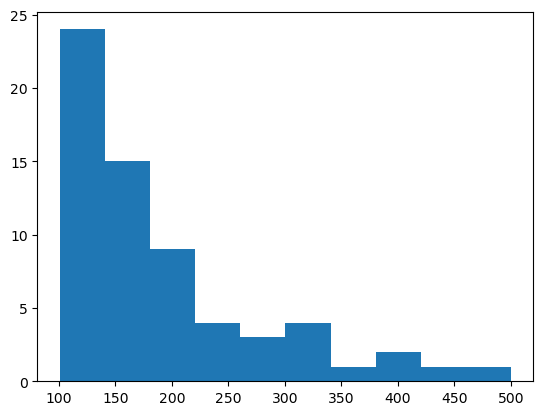

In [ ]:
from src import AFDB_tools
import os
datapath = '../SCOP_data/'
nprots = 500
fams = 2000
total = 0
lengths = []
#iterate over all superfamilies and create a tree for each

if not os.path.exists(datapath):
    os.mkdir(datapath)
    
for i,superfam in enumerate(scopdf.SF.unique()):
    if not os.path.exists(datapath+superfam):
        os.mkdir(datapath+superfam)

    #create a tree for each superfam
    #sample 1000 proteins from the superfam
    sub = scopdf[scopdf.SF == superfam]
    prots = list(sub['SF-UNIID'].unique())
    prots = prots[:nprots]
    #output the sequence dataset to a file
    #create a folder for the superfam if it does not exist
    #output the uniport ids to a file
    if len(prots)> 100:
        lengths.append(len(prots))
        total+=1
        with open(datapath+superfam+'/identifiers.txt', 'w') as f:
            f.write('\n'.join( prots ))
print('done', total)
plt.hist(lengths)
plt.show()


../../../datasets/Structure_Trees_mk2/Bacteria/


100%|██████████| 671/671 [00:20<00:00, 32.43it/s]


../../../datasets/Structure_Trees_mk2/LUCA/


100%|██████████| 1392/1392 [00:33<00:00, 42.02it/s]


../../../datasets/Structure_Trees_mk2/Euteleostomi/


100%|██████████| 3267/3267 [01:22<00:00, 39.54it/s]


../../../datasets/Structure_Trees_mk2/Eumetazoa/


100%|██████████| 1568/1568 [00:35<00:00, 43.59it/s]


../../../datasets/Structure_Trees_mk2/Chordata/


100%|██████████| 1038/1038 [00:27<00:00, 37.52it/s]


../../../datasets/Structure_Trees_mk2/Tetrapoda/


100%|██████████| 359/359 [00:08<00:00, 42.78it/s]


../../../datasets/Structure_Trees_mk2/Opisthokonta/


100%|██████████| 662/662 [00:15<00:00, 42.24it/s]


../../../datasets/Structure_Trees_mk2/Dikarya/


100%|██████████| 186/186 [00:07<00:00, 26.55it/s]


../../../datasets/Structure_Trees_mk2/Fungi/


100%|██████████| 138/138 [00:03<00:00, 39.10it/s]


../../../datasets/Structure_Trees_mk2/Bilateria/


100%|██████████| 1033/1033 [00:27<00:00, 37.12it/s]


../../../datasets/Structure_Trees_mk2/Eukaryota/


100%|██████████| 3218/3218 [02:23<00:00, 22.41it/s]


{'../../../datasets/Structure_Trees_mk2/Bacteria/': 610, '../../../datasets/Structure_Trees_mk2/LUCA/': 1307, '../../../datasets/Structure_Trees_mk2/Euteleostomi/': 3007, '../../../datasets/Structure_Trees_mk2/Eumetazoa/': 1530, '../../../datasets/Structure_Trees_mk2/Chordata/': 1008, '../../../datasets/Structure_Trees_mk2/Tetrapoda/': 165, '../../../datasets/Structure_Trees_mk2/Opisthokonta/': 648, '../../../datasets/Structure_Trees_mk2/Dikarya/': 131, '../../../datasets/Structure_Trees_mk2/Fungi/': 117, '../../../datasets/Structure_Trees_mk2/Bilateria/': 1003, '../../../datasets/Structure_Trees_mk2/Eukaryota/': 3110}


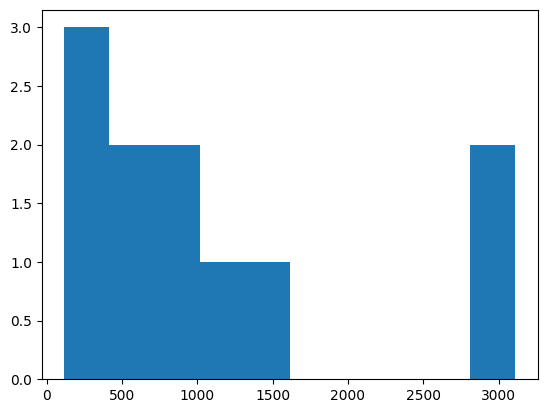

In [38]:
#subsample the oma folders

import os
import shutil
import random
import glob
from tqdm import tqdm
from matplotlib import pyplot as plt



#path to the oma folder
path = '../../../datasets/Structure_Trees_mk2/*/'
#path to the output folder
outpath = '../OMA_data/'

#make the output folder if it does not exist
if not os.path.exists(outpath):
    os.mkdir(outpath)

#number of proteins to sample
min_prots = 10
#number of superfamilies to sample
fams = 2000

superfams={}
#iterate over all superfamilies and compile an identifiers.txt file in the output folder
for clade in glob.glob(path):
    print(clade)
    if clade not in superfams:
        superfams[clade] = {}
    #stores length of each superfam
    superfam = set(glob.glob(clade+'*/'))-set([clade + 'logs/'])
    #use tqdm progress bar
    for s in tqdm(superfam):
        
        with open(clade+s+'identifiers.txt', 'r') as f:
                nprots = len(f.readlines())
        if nprots > min_prots:
            superfams[clade][s] = nprots
lengths = { c:len(superfams[c]) for c in superfams}
print(lengths)
plt.hist(list(lengths.values()))
plt.show()


In [58]:
minlen = min(list(lengths.values()) )
print(minlen)
#clear output directory


#sample the superfamilies
for clade in superfams:
    cladestr = clade.split('/')[-2]+'/'
    if not os.path.isdir(outpath+cladestr):
        os.mkdir(outpath+cladestr)
    print(clade)
    superfams[clade] = random.sample( list(superfams[clade]) , minlen)
    for s in tqdm(superfams[clade]):
        #copy the files to the output folder
        superfam = s.split('/')[-2]+'/'
        if not os.path.exists(outpath+cladestr+superfam):
            os.mkdir(outpath+cladestr+superfam)
            shutil.copy(s+'identifiers.txt', outpath+cladestr+superfam+'identifiers.txt')


117
../../../datasets/Structure_Trees_mk2/Bacteria/


100%|██████████| 117/117 [00:00<00:00, 438.17it/s]


../../../datasets/Structure_Trees_mk2/LUCA/


100%|██████████| 117/117 [00:00<00:00, 32842.56it/s]


../../../datasets/Structure_Trees_mk2/Euteleostomi/


100%|██████████| 117/117 [00:00<00:00, 37731.32it/s]


../../../datasets/Structure_Trees_mk2/Eumetazoa/


100%|██████████| 117/117 [00:00<00:00, 20771.79it/s]


../../../datasets/Structure_Trees_mk2/Chordata/


100%|██████████| 117/117 [00:00<00:00, 9890.23it/s]


../../../datasets/Structure_Trees_mk2/Tetrapoda/


100%|██████████| 117/117 [00:00<00:00, 8259.70it/s]


../../../datasets/Structure_Trees_mk2/Opisthokonta/


100%|██████████| 117/117 [00:00<00:00, 6208.99it/s]


../../../datasets/Structure_Trees_mk2/Dikarya/


100%|██████████| 117/117 [00:00<00:00, 23739.05it/s]


../../../datasets/Structure_Trees_mk2/Fungi/


100%|██████████| 117/117 [00:00<00:00, 9641.32it/s]


../../../datasets/Structure_Trees_mk2/Bilateria/


100%|██████████| 117/117 [00:00<00:00, 927.61it/s]


../../../datasets/Structure_Trees_mk2/Eukaryota/


100%|██████████| 117/117 [00:00<00:00, 331.71it/s]
